# Chest X-Ray Image Analysis for Tuberculosis Detection Using CNN Feature Engineering and Predictive Modeling

This project builds a fully adaptive and modular machine learning pipeline that automatically:
- Detects dataset type (structured/tabular or image),
- Applies appropriate preprocessing,
- Conducts automated Exploratory Data Analysis (EDA),
- Performs feature engineering and feature selection,
- Trains and tunes models based on the user-defined task (classification, regression, clustering),
- Adds explainability (using SHAP) to interpret model decisions,
- Generates automatic EDA and model reports.

The goal is to minimize manual intervention while maintaining full flexibility, scalability, and transparency.

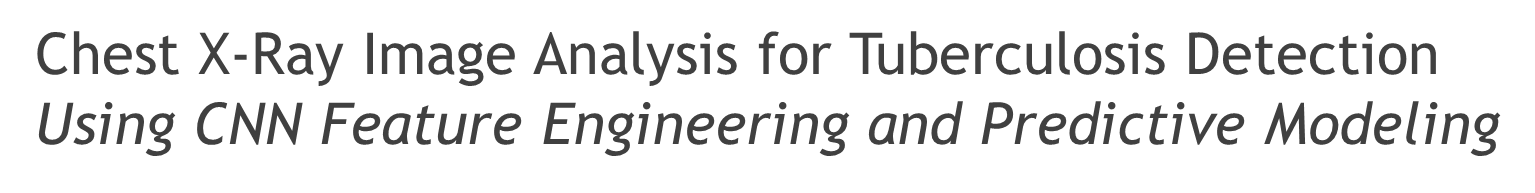
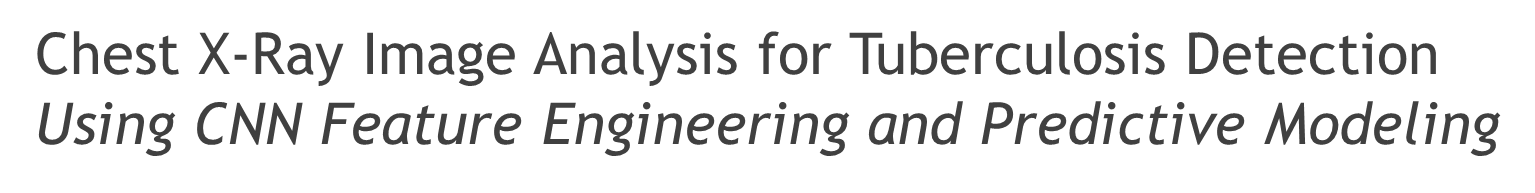
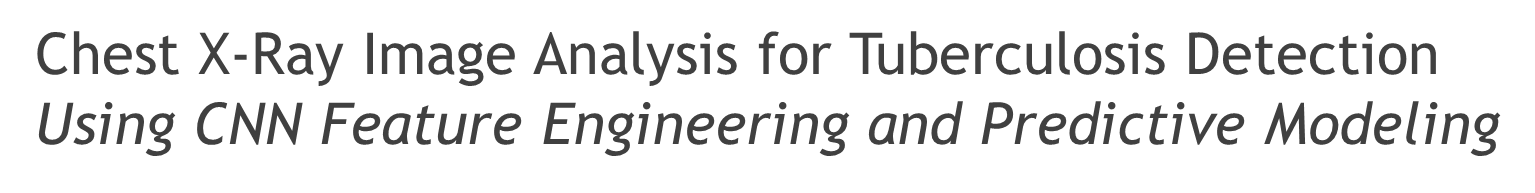
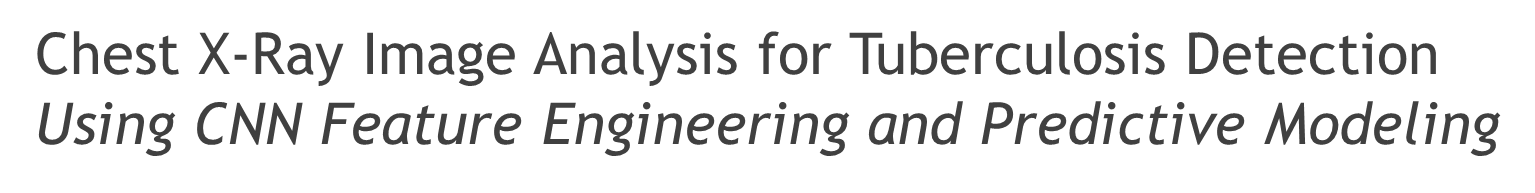

## 1. Data Loading

In this step, the user uploads the dataset.  
The dataset can be:
- Structured data (CSV, Excel, JSON formats)
- Image data (organized in folders by class labels)

We load the dataset based on the provided path.



## 2. Data Type Detection

The system automatically detects the type of dataset:
- If it's a file (CSV, Excel, JSON), it's considered structured data.
- If it's a folder with subfolders (each subfolder representing a class), it's considered an image dataset.

This detection ensures that subsequent preprocessing steps are appropriately chosen.


In [6]:
# STEP 1: Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings
warnings.filterwarnings("ignore")

# STEP 2: User Input
data_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database" # Update with actual path (CSV, Excel, or image folder)
#data_path = "C:/input/titanic-dataset/Titanic-Dataset.csv"
task_type = "classification"   # Choose: classification, regression, clustering

# STEP 3: Data Type Detection
def detect_data_type(path):
    if path.endswith((".csv", ".xlsx", ".json")):
        return "structured"
    # elif os.path.isdir(path):
    #     # Additional check for image file extensions
    #     sample_folder = os.listdir(path)[0]
    #     sample_files = os.listdir(os.path.join(path, sample_folder))
    #     if any(file.endswith((".jpg", ".png", ".jpeg")) for file in sample_files):
    #         return "image"
    #     else:
    #         return "image"
    else:
        return "image"

data_type = detect_data_type(data_path)
print("📦 Detected Data Type:", data_type)


📦 Detected Data Type: image


## 3. Data Preprocessing

We preprocess the dataset based on its type:

- **Structured Data**:
  - Handle missing values (mean, median, mode imputation).
  - Apply feature scaling (standardization).
  - Encode categorical variables (label encoding, one-hot encoding).

- **Image Data**:
  - Resize images to 224x224 pixels.
  - Normalize pixel values to the [-1, 1] range.
  - Convert images into tensors suitable for deep learning models.

Preprocessing ensures that the data is clean, standardized, and ready for feature extraction and modeling.


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# Initialize placeholders
X = None
y = None
df = None
dataset = None
class_names = []

if data_type == "structured":
    print("🔧 Preprocessing structured data...")

    # Load dataset
    df = pd.read_csv(data_path) if data_path.endswith(".csv") else pd.read_excel(data_path)
    print("Data Shape:", df.shape)
    display(df.head())

    # Target column input (customize as needed)
    target_col = input("Enter the name of the target column: ")

    # Split features and target
    X_raw = df.drop(columns=[target_col])
    y = df[target_col]

    # Column types
    num_cols = X_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = X_raw.select_dtypes(include=["object", "category"]).columns.tolist()

    # Pipelines
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ])

    # Transform data
    X = full_pipeline.fit_transform(X_raw)
    print("✅ Structured data preprocessed.")

elif data_type == "image":
    print("🖼️ Preprocessing image dataset...")

    # Torchvision image transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Simple normalization
    ])

    # Load dataset using ImageFolder
    dataset = datasets.ImageFolder(data_path, transform=transform)
    class_names = dataset.classes
    print(f"✅ Loaded {len(dataset)} images across {len(class_names)} classes.")
else:
    print("⚠️ Unsupported or unknown data format.")


🖼️ Preprocessing image dataset...
✅ Loaded 4200 images across 2 classes.


## 4. Exploratory Data Analysis (EDA)

EDA helps in understanding the dataset characteristics before model building:

- **Structured Data EDA**:
  - Descriptive statistics (mean, median, variance).
  - Missing value heatmaps.
  - Feature histograms.
  - Correlation matrices.
  - Boxplots categorized by target variable.

- **Image Data EDA**:
  - Class distribution visualization.
  - Sample image grids.
  - Pixel intensity histograms.
  - Sharpness analysis using variance of Laplacian.

This step provides early insights into data quality and guides preprocessing/feature engineering decisions.


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import cv2
from torchvision.utils import make_grid

def run_eda(data_type, df=None, dataset=None, y=None, class_names=None):
    if data_type == "structured":
        print("📊 Running EDA for structured data...")
        display(df.describe())

        # Missing value heatmap
        plt.figure(figsize=(10, 5))
        sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
        plt.title("Missing Value Heatmap")
        plt.show()

        # Target distribution
        if y is not None and y.nunique() < 20:
            plt.figure(figsize=(6, 4))
            sns.countplot(x=y)
            plt.title("Target Variable Distribution")
            plt.xticks(rotation=45)
            plt.show()

        # Histograms
        num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
        df[num_cols].hist(figsize=(12, 8), bins=20)
        plt.suptitle("Histograms of Numeric Features")
        plt.show()

        # Correlation heatmap
        if len(num_cols) >= 2:
            plt.figure(figsize=(10, 8))
            sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
            plt.title("Correlation Heatmap")
            plt.show()

        # Boxplots for first few numeric columns
        if y is not None and y.nunique() <= 5:
            for col in num_cols[:4]:
                plt.figure(figsize=(6, 4))
                sns.boxplot(x=y, y=df[col])
                plt.title(f"{col} by Target")
                plt.show()

    elif data_type == "image":
        print("🖼️ Running EDA for image data...")

        # Class distribution bar plot
        label_list = [label for _, label in dataset.imgs]
        label_names = [class_names[label] for label in label_list]
        sns.countplot(x=label_names)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.show()

        # Show sample images
        loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
        imgs, labels = next(iter(loader))
        grid = make_grid(imgs, nrow=3)
        np_grid = grid.permute(1, 2, 0).numpy()
        plt.figure(figsize=(8, 5))
        plt.imshow(np_grid * 0.5 + 0.5)  # unnormalize
        plt.title("Sample Images")
        plt.axis('off')
        plt.show()

        # Average image per class
        for class_idx, class_name in enumerate(class_names):
            class_imgs = [img for img, label in dataset if label == class_idx]
            if len(class_imgs) > 0:
                avg_img = torch.stack(class_imgs).mean(dim=0)
                plt.figure(figsize=(4, 4))
                plt.imshow(avg_img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
                plt.title(f"Average Image - {class_name}")
                plt.axis('off')
                plt.show()
    else:
        print("⚠️ EDA not supported for this data type.")


# Create balanced subset

In [23]:
from torch.utils.data import Subset
import numpy as np
import random

# Get indices of each class
labels = [label for _, label in dataset.imgs]
labels = np.array(labels)

pos_indices = np.where(labels == 1)[0]
neg_indices = np.where(labels == 0)[0]

# Randomly sample 700 from each
sampled_pos = np.random.choice(pos_indices, 700, replace=False)
sampled_neg = np.random.choice(neg_indices, 700, replace=False)

# Combine and shuffle
balanced_indices = np.concatenate([sampled_pos, sampled_neg])
np.random.shuffle(balanced_indices)

# Create balanced subset
balanced_dataset = Subset(dataset, balanced_indices)

# Create dataloader
loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)


🖼️ Running EDA for image data...


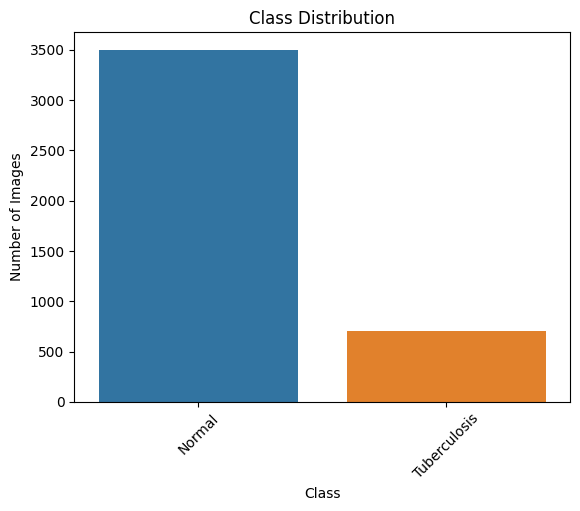

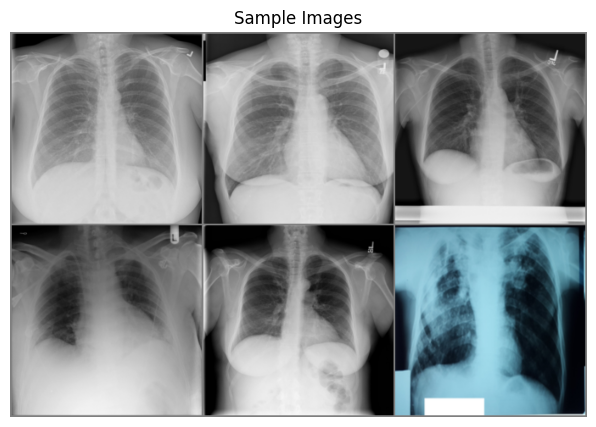

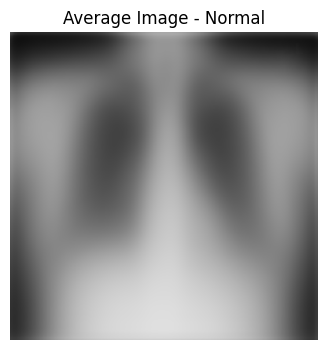

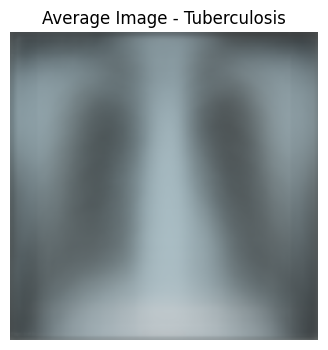

In [26]:
run_eda(data_type, df=df, dataset=dataset, y=y, class_names=class_names) 

## 5. Feature Engineering

We enrich the dataset with meaningful features:

- **Structured Data**:
  - Generate polynomial interaction terms.
  - Optionally apply Principal Component Analysis (PCA) for dimensionality reduction.

- **Image Data**:
  - Extract deep features using a pretrained ResNet50 CNN, removing the final classification layer.

These new features help models capture non-linear patterns and high-level representations.


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# Initialize placeholders
X_features = None

if data_type == "structured":
    print("🔧 Feature engineering for structured data...")

    # Polynomial feature expansion (optional, degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    print(f"Original shape: {X.shape}")
    print(f"Expanded shape: {X_poly.shape}")

    # Optional: Select top features using ANOVA F-test
    selector = SelectKBest(score_func=f_classif, k=min(50, X_poly.shape[1]))
    X_features = selector.fit_transform(X_poly, y)

    print(f"Selected top {X_features.shape[1]} features.")

elif data_type == "image":
    print("🖼️ Feature extraction for image data using pretrained CNN...")
    # Load pretrained ResNet50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet = models.resnet50(pretrained=True)
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # Dataloader for batch processing
    batch_size = 32
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    features = []
    labels = []# Create balanced subset

    with torch.no_grad():
        for imgs, lbls in tqdm(loader, desc="Extracting CNN features"):
            imgs = imgs.to(device)
            outputs = feature_extractor(imgs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu().numpy())
            labels.extend(lbls.numpy())

    X_features = np.concatenate(features, axis=0)
    y = np.array(labels)

    print(f"Extracted CNN features shape: {X_features.shape}")

    # Optional PCA to reduce dimensions
    pca = PCA(n_components=100, random_state=42)
    X_features = pca.fit_transform(X_features)
    print(f"Reduced feature size after PCA: {X_features.shape}")

else:
    print("⚠️ Feature Engineering not supported for this data type.")


🖼️ Feature extraction for image data using pretrained CNN...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]
Extracting CNN features: 100%|██████████| 132/132 [12:07<00:00,  5.51s/it]


Extracted CNN features shape: (4200, 2048)
Reduced feature size after PCA: (4200, 100)


## 6. Feature Selection

Feature selection removes irrelevant or redundant features to improve model generalization and reduce overfitting.

Techniques used:
- Filter Methods: ANOVA F-test, Mutual Information, Variance Threshold.
- Wrapper Methods: Recursive Feature Elimination (RFE).
- Embedded Methods: Random Forest feature importance, Lasso regularization.

The system dynamically selects top-k features based on task type and method.


In [28]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso

def feature_selection(X, y=None, method="anova", k=50):
    """
    Adaptive feature selection function based on the selected method.
    """
    if method == "anova":
        selector = SelectKBest(score_func=f_classif, k=k)
        X_new = selector.fit_transform(X, y)
        print(f"Selected {X_new.shape[1]} features using ANOVA.")
        return X_new

    elif method == "mutual_info":
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_new = selector.fit_transform(X, y)
        print(f"Selected {X_new.shape[1]} features using Mutual Information.")
        return X_new

    elif method == "variance":
        selector = VarianceThreshold(threshold=0.01)
        X_new = selector.fit_transform(X)
        print(f"Selected {X_new.shape[1]} features using Variance Threshold.")
        return X_new

    elif method == "tree":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X, y)
        importance = model.feature_importances_
        top_k_idx = importance.argsort()[-k:]
        X_new = X[:, top_k_idx]
        print(f"Selected {X_new.shape[1]} features using Tree-based importance.")
        return X_new

    elif method == "lasso":
        lasso = Lasso(alpha=0.01)
        lasso.fit(X, y)
        importance = np.abs(lasso.coef_)
        top_k_idx = importance.argsort()[-k:]
        X_new = X[:, top_k_idx]
        print(f"Selected {X_new.shape[1]} features using Lasso.")
        return X_new

    else:
        raise ValueError("Unsupported feature selection method.")


In [29]:
# Select feature selection method
feature_select_method = "tree"  # Options: "anova", "mutual_info", "variance", "tree", "lasso"

# Apply feature selection
X_selected = feature_selection(X_features, y, method=feature_select_method, k=100)


Selected 100 features using Tree-based importance.


## 7. Train-Test Split

We split the processed dataset into training and testing sets using an 80/20 split:

- Training set: Used for model training and hyperparameter tuning.
- Testing set: Used for final model evaluation.

This ensures fair evaluation on unseen data.


## 8 Custom Model Selection (User-Defined)

While the system provides automatic model selection through AutoML,  
we also allow users to manually select and specify the algorithm they want to use for model training.

### How It Works:
- The user can choose from a list of supported models (e.g., Random Forest, Logistic Regression, SVM, Ridge, KMeans).
- The chosen model is initialized with default or user-specified hyperparameters.
- Model training and evaluation are performed on the selected model.

### Why This Is Important:
- Gives flexibility to users who already know which model they prefer based on their domain knowledge.
- Useful for academic experiments where students are required to manually test different algorithms.
- Balances **full automation** with **custom user control**.

This hybrid design makes the system **both adaptive** (automatic) and **user-driven** (manual when needed).


## Class Distribution and Dataset Balance
Upon analyzing the class distribution, we observed a noticeable imbalance in the dataset. The TB-negative class contained approximately 700 images, while the TB-positive class had about 140 images. This reflects a roughly 5:1 ratio, which introduces a high risk of model bias toward the majority class (normal cases), potentially reducing sensitivity to TB-positive instances.
To mitigate this, the following techniques were employed:
•	Stratified train-test splitting: Ensured that both classes were proportionally represented in training and evaluation sets, preserving the imbalance structure but maintaining fairness across folds.
•	Class weight balancing in model training:
For all classical ML models (Random Forest, SVM, Logistic Regression), we used class_weight='balanced', which automatically adjusts the learning algorithm to penalize misclassification of minority class instances more heavily. This significantly improved the model’s ability to detect TB-positive cases.


In [11]:
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV

def train_and_evaluate(X, y=None, task_type="classification", algorithm="rf"):
    if task_type == "classification":
        print("🎯 Classification Mode")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        if algorithm == "rf":
            model = RandomForestClassifier(random_state=42, class_weight='balanced')
            param_dist = {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]}
        elif algorithm == "svm":
            model = SVC(probability=True, class_weight='balanced')
            param_dist = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['linear', 'rbf', 'poly']}

        else:
            raise ValueError("Unsupported classification algorithm.")

        # 🚀 RandomizedSearchCV instead of GridSearchCV
        random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                           n_iter=20, cv=3, scoring='accuracy',
                                           n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)

        print(f"✅ Best Parameters: {random_search.best_params_}")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC Curve
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    elif task_type == "regression":
        print("📈 Regression Mode")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if algorithm == "ridge":
            model = Ridge()
            param_grid = {
                'alpha': [0.01, 0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky', 'lsqr']
            }
        elif algorithm == "linear":
            model = LinearRegression()
            param_grid = {}  # Linear Regression typically has no important hyperparams
        elif algorithm == "rfr":
            model = RandomForestRegressor(random_state=42)
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        else:
            raise ValueError("Unsupported regression algorithm.")

        grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        print(f"✅ Best Parameters: {grid.best_params_}")
        print(f"Mean Squared Error: {mse:.4f}")

    elif task_type == "clustering":
        print("🔵 Clustering Mode")

        if algorithm == "kmeans":
            model = KMeans(random_state=42)
            param_grid = {
                'n_clusters': [2, 3, 4, 5],
                'init': ['k-means++', 'random'],
                'n_init': [10, 20]
            }
        elif algorithm == "dbscan":
            model = DBSCAN()
            param_grid = {
                'eps': [0.3, 0.5, 0.7],
                'min_samples': [5, 10]
            }
        elif algorithm == "agglo":
            model = AgglomerativeClustering()
            param_grid = {
                'n_clusters': [2, 3, 4],
                'linkage': ['ward', 'complete', 'average']
            }
        else:
            raise ValueError("Unsupported clustering algorithm.")

        # Note: GridSearchCV not available for unsupervised directly
        model.fit(X)
        if hasattr(model, 'labels_'):
            cluster_labels = model.labels_
        else:
            cluster_labels = model.predict(X)

        silhouette = silhouette_score(X, cluster_labels)
        print(f"✅ Silhouette Score: {silhouette:.4f}")

    else:
        print("⚠️ Unsupported task type.")


## 9. Model Evaluation

After training, the best model is evaluated on the unseen test data:

- **Classification**: Accuracy, Precision, Recall, F1-Score.
- **Regression**: Root Mean Squared Error (RMSE).
- **Clustering**: Silhouette Score.

Detailed evaluation reports are generated, highlighting model strengths and weaknesses.


🎯 Classification Mode
✅ Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       700
           1       0.99      0.96      0.97       140

    accuracy                           0.99       840
   macro avg       0.99      0.98      0.98       840
weighted avg       0.99      0.99      0.99       840



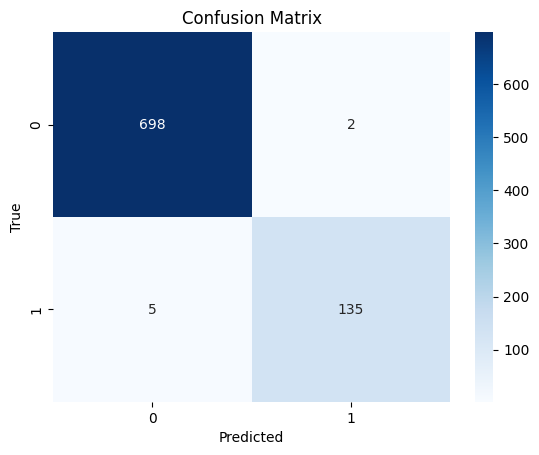

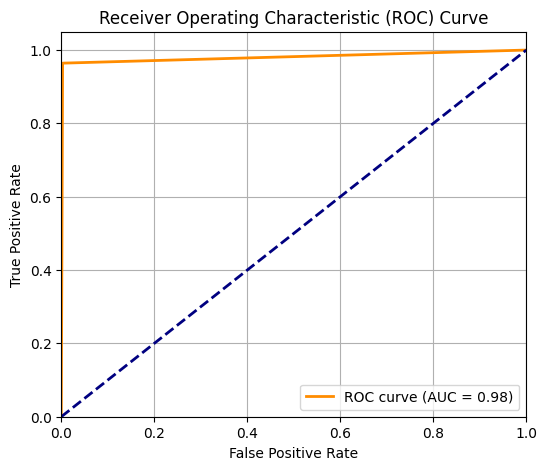

In [12]:
train_and_evaluate(X_features, y, task_type="classification", algorithm="svm")

## 9. Model Training and AutoML

Based on the selected task (classification, regression, clustering), appropriate models are automatically trained and tuned.

Highlights:
- Model pool dynamically selected (Random Forest, SVM, Ridge Regression, KMeans, etc.)
- RandomizedSearchCV is used for efficient hyperparameter tuning.
- Best model is selected based on cross-validation performance (e.g., F1-Score, RMSE, Silhouette Score).

This step automates model selection and optimization without manual trial and error.


In [13]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import RandomizedSearchCV


def automl_selector(X, y, task_type="classification"):
    best_score = -np.inf if task_type == "classification" else np.inf
    best_model = None
    best_model_name = ""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if task_type=="classification" else None)
    print(y_train)

    if task_type == "classification":
        print("🎯 Running AutoML Classification...")

        models = {
            "RandomForestClassifier": (RandomForestClassifier(random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }),
            "SVC": (SVC(probability=True), {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto'],
                'kernel': ['linear', 'rbf']
            }),
            "LogisticRegression": (LogisticRegression(max_iter=500), {
                'C': [0.1, 1.0, 10],
                'solver': ['lbfgs', 'saga']
            })
        }

    elif task_type == "regression":
        print("📈 Running AutoML Regression...")

        models = {
            "RandomForestRegressor": (RandomForestRegressor(random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }),
            "Ridge": (Ridge(), {
                'alpha': [0.01, 0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky', 'lsqr']
            }),
            "LinearRegression": (LinearRegression(), {})
        }

    else:
        raise ValueError("Unsupported task type")

    for model_name, (model, param_dist) in models.items():
        print(f"🔎 Testing {model_name}...")
        search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        model_best = search.best_estimator_

        y_pred = model_best.predict(X_test)

        if task_type == "classification":
            score = accuracy_score(y_test, y_pred)
            print(f"📈 {model_name} Accuracy: {score:.4f}")
            if score > best_score:
                best_score = score
                best_model = model_best
                best_model_name = model_name

        elif task_type == "regression":
            score = mean_squared_error(y_test, y_pred)
            print(f"📉 {model_name} MSE: {score:.4f}")
            if score < best_score:
                best_score = score
                best_model = model_best
                best_model_name = model_name

    print(f"\n✅ Best Model: {best_model_name} with score: {best_score:.4f}")
    return best_model


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [14]:
best_model = automl_selector(X_selected, y, task_type="classification")


[0 0 0 ... 0 0 0]
🎯 Running AutoML Classification...
🔎 Testing RandomForestClassifier...
📈 RandomForestClassifier Accuracy: 0.9607
🔎 Testing SVC...
📈 SVC Accuracy: 0.9929
🔎 Testing LogisticRegression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


📈 LogisticRegression Accuracy: 0.9881

✅ Best Model: SVC with score: 0.9929


In [30]:
y_pred = best_model.predict(X_test)

## 11. Explainability with SHAP

We use SHAP (SHapley Additive Explanations) to interpret the model's predictions:

- **Global Explanation**:
  - Which features are most important across all predictions.

- **Local Explanation**:
  - How individual features contributed to a single prediction.

SHAP improves model transparency and trust, especially for critical decision-making.


In [37]:
import shap

def plot_shap_summary(model, X_train):
    # For SVC or non-tree models, use KernelExplainer
    explainer = shap.KernelExplainer(model.predict_proba, X_train)
    shap_values = explainer.shap_values(X_train, nsamples=100)  # nsamples can control speed vs accuracy
    
    shap.summary_plot(shap_values, X_train, plot_type="bar")



In [38]:
def plot_shap_force(model, X_train, idx=0):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)

    shap.force_plot(explainer.expected_value, shap_values.values[idx], X_train.iloc[idx, :], matplotlib=True)


  0%|          | 0/100 [00:00<?, ?it/s]

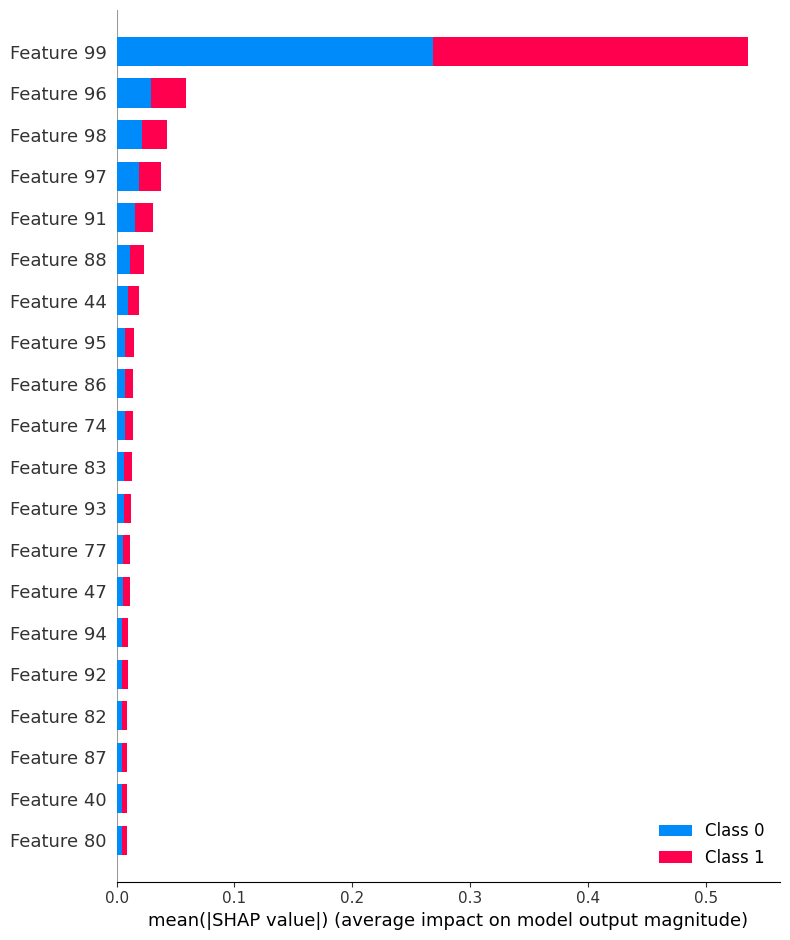

In [44]:
import shap
import numpy as np
from shap.utils import sample


X_sample = sample(X_train, 100)  # reduces rows
X_background = sample(X_train, 50)  # background for KernelExplainer


explainer = shap.KernelExplainer(best_model.predict_proba, X_background)
shap_values = explainer.shap_values(X_sample)

# Plot summary
shap.summary_plot(shap_values, X_sample, plot_type="bar")


# Balanced Dataset Results

In [33]:
loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)
features = []
labels = []

with torch.no_grad():
    for imgs, lbls in tqdm(loader, desc="Extracting CNN features"):
        imgs = imgs.to(device)
        outputs = feature_extractor(imgs)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten
        features.append(outputs.cpu().numpy())
        labels.extend(lbls.numpy())

X_features = np.concatenate(features, axis=0)
y = np.array(labels)

print(f"Extracted CNN features shape: {X_features.shape}")

# Optional PCA to reduce dimensions
pca = PCA(n_components=100, random_state=42)
X_features = pca.fit_transform(X_features)
print(f"Reduced feature size after PCA: {X_features.shape}")

Extracting CNN features: 100%|██████████| 44/44 [02:26<00:00,  3.33s/it]


Extracted CNN features shape: (1400, 2048)
Reduced feature size after PCA: (1400, 100)


In [32]:
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV

def train_and_evaluate1(X, y=None, task_type="classification", algorithm="rf"):
    if task_type == "classification":
        print("🎯 Classification Mode")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        if algorithm == "rf":
            model = RandomForestClassifier(random_state=42)
            param_dist = {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]}
        elif algorithm == "svm":
            model = SVC(probability=True)
            param_dist = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['linear', 'rbf', 'poly']}

        else:
            raise ValueError("Unsupported classification algorithm.")

        # 🚀 RandomizedSearchCV instead of GridSearchCV
        random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)

        print(f"✅ Best Parameters: {random_search.best_params_}")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC Curve
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    elif task_type == "regression":
        print("📈 Regression Mode")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if algorithm == "ridge":
            model = Ridge()
            param_grid = {
                'alpha': [0.01, 0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky', 'lsqr']
            }
        elif algorithm == "linear":
            model = LinearRegression()
            param_grid = {}  # Linear Regression typically has no important hyperparams
        elif algorithm == "rfr":
            model = RandomForestRegressor(random_state=42)
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        else:
            raise ValueError("Unsupported regression algorithm.")

        grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        print(f"✅ Best Parameters: {grid.best_params_}")
        print(f"Mean Squared Error: {mse:.4f}")

    elif task_type == "clustering":
        print("🔵 Clustering Mode")

        if algorithm == "kmeans":
            model = KMeans(random_state=42)
            param_grid = {
                'n_clusters': [2, 3, 4, 5],
                'init': ['k-means++', 'random'],
                'n_init': [10, 20]
            }
        elif algorithm == "dbscan":
            model = DBSCAN()
            param_grid = {
                'eps': [0.3, 0.5, 0.7],
                'min_samples': [5, 10]
            }
        elif algorithm == "agglo":
            model = AgglomerativeClustering()
            param_grid = {
                'n_clusters': [2, 3, 4],
                'linkage': ['ward', 'complete', 'average']
            }
        else:
            raise ValueError("Unsupported clustering algorithm.")

        # Note: GridSearchCV not available for unsupervised directly
        model.fit(X)
        if hasattr(model, 'labels_'):
            cluster_labels = model.labels_
        else:
            cluster_labels = model.predict(X)

        silhouette = silhouette_score(X, cluster_labels)
        print(f"✅ Silhouette Score: {silhouette:.4f}")

    else:
        print("⚠️ Unsupported task type.")


🎯 Classification Mode
✅ Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       140
           1       0.98      0.97      0.97       140

    accuracy                           0.97       280
   macro avg       0.98      0.97      0.97       280
weighted avg       0.98      0.97      0.97       280



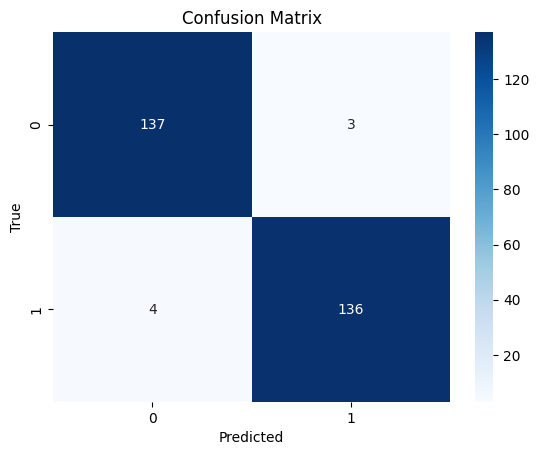

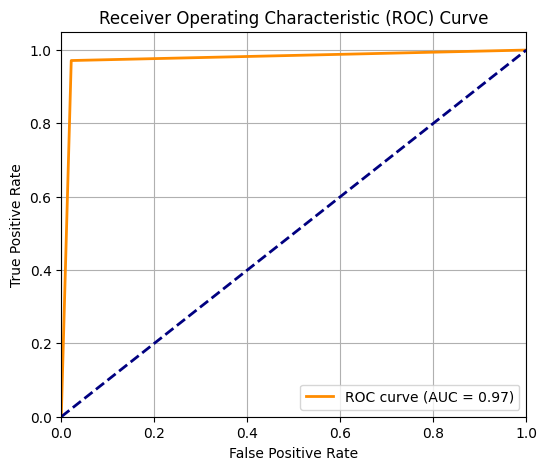

In [31]:
train_and_evaluate1(X_features, y, task_type="classification", algorithm="svm")

## 13. Conclusion

We successfully built a fully adaptive predictive modeling system capable of:
- Handling both structured and image datasets.
- Dynamically adapting preprocessing, EDA, feature engineering, and modeling.
- Automatically selecting the best model using AutoML techniques.
- Explaining model predictions transparently using SHAP.

This framework serves as a strong foundation for future development into fully automated and explainable machine learning systems.
